In [87]:
using Random
using Plots

# Feed Forward Networks

## A non-linear Example

Consider the following dataset:

In [88]:
x = range(1, 10, 100);
y = (x.-2).^2;

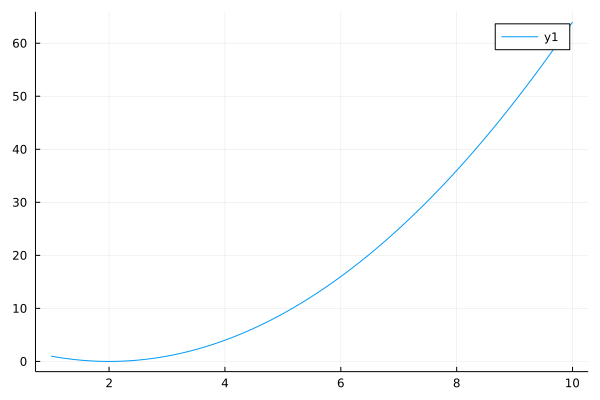

In [89]:
plot(x, y)

### Implementing Linear Regression

If we adapted the method from before we could fit a linear regression to it like so:

In [90]:
function model(m, b, xv)
    return m * x .+ b
end

m = rand()
b = rand()
yhat = model(m, b, x)

0.3257906856567552:0.02701223236099325:3.000001689395087

This model is random though, so it's not a very good fit.

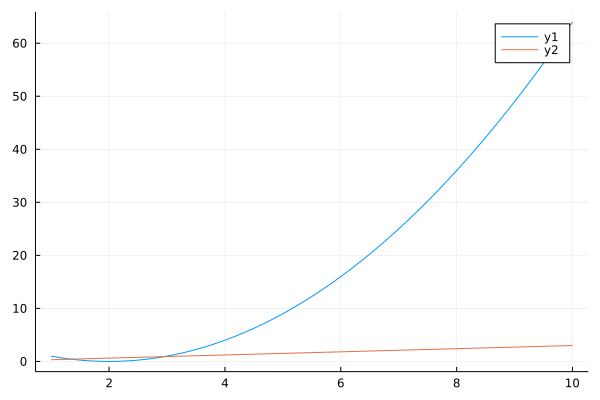

In [91]:
plot(x, y)
plot!(x, yhat)

If we implement our gradient, loss and optimiser functions:

In [92]:
function mgrad(x, y, m, b)
    grad = sum(-2 *x .* (y - m * x .+ b))
    return grad
end

function bgrad(x, y, m, b)
    grad = sum(2 * (y - m * x .+ b))
    return grad
end

bgrad (generic function with 1 method)

In [93]:
rss(y, yhat) = sum(((y-yhat).^2)/100)

rss (generic function with 1 method)

In [94]:
lr = 0.00001
function opt(mg, bg, m, b, lr)
    m -= lr * mg
    b -= lr * bg

    return m,b
end

opt (generic function with 1 method)

We can train our model with a loop:

In [95]:
losses = []
EPOCHS = 100

for i=1:100
    # Fit the model
    yhat = model(m, b, x)
    
    # Measure the loss
    loss = rss(yhat, y)
    append!(losses, loss)
    
    # Calculate the gradients
    mg = mgrad(x, y, m, b)
    bg = bgrad(x, y, m, b)
    
    # Backpropogate
    m, b = opt(mg, bg, m, b, lr)
end

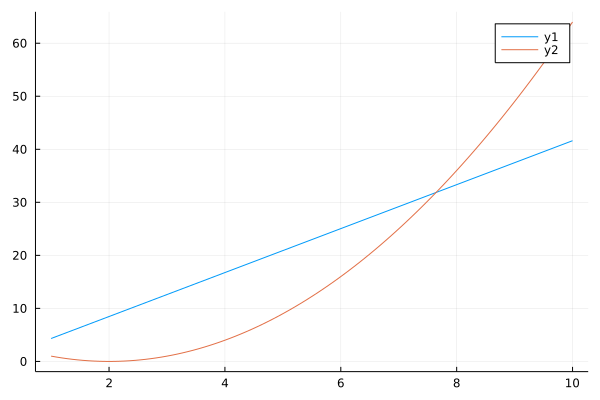

In [96]:
yhat = model(m, b, x)
plot(x, yhat)
plot!(x, y)

Unfourtunately, a linear model **will not work** for a quadratic function.

### A non-linear fix

So instead we change our model, instead of just doing linear regression, we round it off, and then do linear regression on the result!

There are a few choices for how we round it off, we can do a literal `round()` (but then differentiation doesn't work well because of all the 0s), we can use a sigmoid, or we can use a compromise that's become pretty common:

In [97]:
function relu(x)
    if x > 0
        return x
    else
        return 0
    end
end

# Derivative of relu is step
function drelu(x)
    if x > 0
        return 1
    else
        return 0
    end
end

drelu (generic function with 1 method)

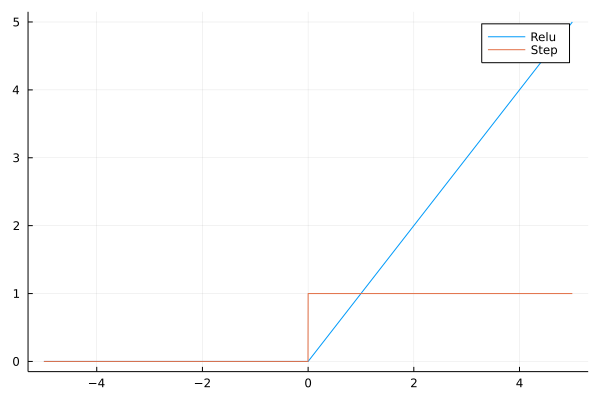

In [98]:
plot(relu,   label = "Relu")
plot!(drelu, label = "Step")

We can use this *activation function* and it's derivative with our model and use the the chain rule to get the derivatives.

Let's consider our new model (the matrix sizes have been annotated):

$$
\underset{1\times N}{\underbrace{\mathbf{\hat{Y}}}}=\underset{1\times3}{\underbrace{\mathbf{A}}}\overset{3\times N}{\overbrace{{\rm relu}\left(\underset{3\times1}{\underbrace{\mathbf{B}}}\underset{1\times N}{\underbrace{\mathbf{X}}}\right)}}
$$

In [99]:
function sigmoid(x)
    1/(1+exp(x))
end

function dsig(x)
    -exp(x)/(exp(x)+1)^2
end

dsig (generic function with 1 method)

In [100]:
# relu(x) = sin(x)
# drelu(x) = cos(x)

This can be expressed in julia like so

In [101]:
x = range(-1, 1, 100);
y = x.^2;

x = Matrix(reshape(x, (1, :)))
y = Matrix(reshape(y, (1, :)))

1×100 Matrix{Float64}:
 1.0  0.960004  0.920824  0.882461  …  0.882461  0.920824  0.960004  1.0

In [102]:
A = rand(1, 3)
B = rand(3, 1)*5

function nn(A, B, x)
    return (A * relu.(B*x))
end
yhat = nn(A, B, x)

1×100 Matrix{Any}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  2.2243  2.27214  2.31997  2.36781

Note that x,y have been transposed such that each column is an observation

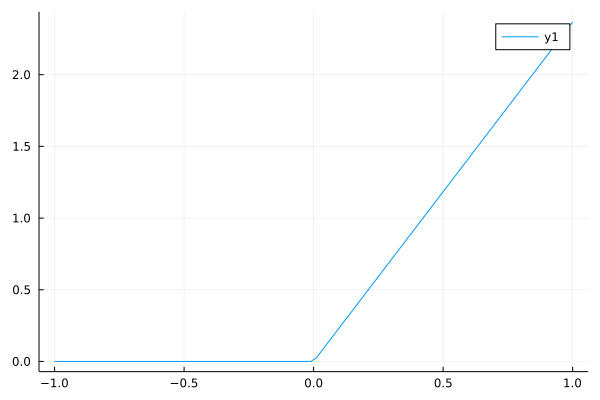

In [103]:
yhat = nn(A, B, x)
plot(x', vec(yhat))

TODO this is wrong, test it in R:


```r
A = matrix(runif(3), 1, 6)
B = matrix(runif(3), 6, 1)
 relu <- function(x) {
        x*(x>0)
    }
nn <-function(A, B, x) {
        return (A %*% relu(B %*% x))
    }

x    = seq(from = -5, to = 5, length.out = 50)
yhat = nn(A, B, seq(from = -5, to = 5, length.out = 50))

plot(x, yhat)
```

### A Detour into Matrices and Calculus

Unfourtunately we now have to deal with vector calculus, which is awful. Consider this example:

\begin{align*}
{\bf T} & ={\bf W}{\bf X}\\
{\bf T}_{\left[i,j\right]} & =\sum_{k=1}^{{\tt ncol}\left(\mathbf{W}\right)}\left[{\bf W}_{\left[i,k\right]}{\bf X}_{\left[k,j\right]}\right]
\end{align*}



#### 4D Tensors into Matrices

The first thing to note are these two identities, assuming $\mathbf{X}$ contains observations.

If each column is an observation (like in Julia):

$$
p = q \implies \frac{\partial{\bf T}_{pi}}{\partial{\bf W}_{qj}} = 0
$$

For this reason, the 4D gradient tensor can be reduced to a 2D tensor and a convenient notation is used where we just *pretend* the gradient tensor is 2D:

$$
\left(\frac{\partial{\bf T}}{\partial{\bf W}}\right)_{\left[i,j\right]}=\frac{\partial{\bf T}_{qi}}{\partial{\bf W}_{qj}}
$$


In the *Matrix Cookbook* this is expressed as:

$$
\left(\frac{\partial{\bf T}}{\partial{\bf W}}\right)_{\left[i,j\right]}=\frac{\partial{\bf T}_{pi}}{\partial{\bf W}_{qj}}\mathbf{I}_{pq}
$$

That way the identity matrix zeros out when they're not equal.

#### Solving the Gradient

\begin{align*}
{\bf T} & ={\bf W}{\bf X}\\
{\bf T}_{ij} & =\sum_{k=1}^{{\tt ncol}\left(\mathbf{W}\right)}\left[{\bf W}_{ik}{\bf X}_{kj}\right]\\
\left(\frac{\partial{\bf T}}{\partial{\bf W}}\right)_{\left[i,j\right]}=\frac{\partial{\bf T}_{qi}}{\partial{\bf W}_{qj}} & =\frac{\partial}{\partial{\bf W}_{qj}}\left(\sum_{k=1}^{N}\left[{\bf W}_{qk}{\bf X}_{kj}\right]\right)\\
 & =\underset{k<q}{\underbrace{0+0+0+\cdots}}+\frac{\partial}{\partial{\bf W}_{qj}}\left({\bf W}_{qj}{\bf X}_{ji}\right)+\underset{k>q}{\underbrace{0+0+0+\cdots}}\\
 & =\frac{\partial}{\partial{\bf W}_{qj}}\left({\bf W}_{qj}{\bf X}_{ji}\right)\\
 & ={\bf X}_{ji}\\
\implies\frac{\partial{\bf T}}{\partial{\bf W}} & ={\bf X}^{{\rm T}}
\end{align*}



Similarly for the gradient of the observations:

\begin{align*}
\frac{\partial{\bf T}_{qi}}{\partial{\bf X}_{qj}} & =\frac{\partial}{\partial{\bf X}_{qj}}\left(\sum_{k=1}^{{\tt nrow}\left({\bf W}\right)}\left[{\bf W}_{ik}{\bf X}_{kj}\right]\right)\\
 & =\frac{\partial}{\partial{\bf X}_{jq}}\left({\bf W}_{ij}{\bf X}_{jq}\right)\\
 &= {\bf W}_{ij}
\end{align*}





#### Transpose for Row Major

You can transpose all this to get the same result for row-major:

If each row is an observation (like in python):

$$
p = q \implies \frac{\partial{\bf T}_{ip}}{\partial{\bf W}_{jq}} = 0
$$

And the tensor is expressed as:

$$
\left(\frac{\partial{\bf T}}{\partial{\bf W}}\right)_{\left[i,j\right]}=\frac{\partial{\bf T}_{ip}}{\partial{\bf W}_{jp}}
$$

### TODO Using the Chain Rule

Now we can take our model:

$$
\underset{1\times N}{\underbrace{\mathbf{\hat{Y}}}}=\underset{1\times3}{\underbrace{\mathbf{A}}}\overset{3\times N}{\overbrace{{\rm relu}\left(\underset{3\times1}{\underbrace{\mathbf{B}}}\underset{1\times N}{\underbrace{\mathbf{X}}}\right)}}
$$

and solve:

TODO show why the transpose checks out.

$$
\frac{\partial\varepsilon}{\partial{\bf A}}=\frac{\partial\hat{y}}{\partial{\bf A}}\left(\frac{\partial\varepsilon}{\partial\hat{y}}\right)^{{\rm T}}
$$

$$
\frac{\partial\varepsilon}{\partial{\bf B}}=\frac{\partial\varepsilon}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial{\bf A}}\frac{\partial{\bf A}}{\partial{\rm relu}}\frac{\partial{\rm relu}}{\partial{\bf \left({\bf B}{\bf X}\right)}}\frac{\partial{\bf \left({\bf B}{\bf X}\right)}}{\partial{\bf B}}
$$

Now efore we go any further, the data has been reshaped so that each observation is a column and features are rows:

In [104]:
x = range(-1, 1, 100);
y = x.^2;
# y = (x.+3).^2;

x = x'
y = y'

1×100 adjoint(::Vector{Float64}) with eltype Float64:
 1.0  0.960004  0.920824  0.882461  …  0.882461  0.920824  0.960004  1.0

In [105]:
function Agrad(x, A, B, y, yhat)
    # Beware, this transpose makes this vector an 1XN matrix
    # it's not the transpose in the math
   
    dedy = 2*(yhat-y)
    dyda = relu.(B*x)
    
    return dedy * dyda'
end

Agrad (generic function with 1 method)

In [106]:
Agrad(x, A, B, y, yhat)

1×3 Matrix{Any}:
 150.314  188.0  172.041

In an ideal world we would do something like this:

$$
\frac{{\rm d}\varepsilon}{{\rm d}B}=\frac{{\rm d}\varepsilon}{{\rm d}\hat{y}}\frac{{\rm d}\hat{y}}{{\rm d}{\rm relu}}\frac{{\rm d}{\rm relu}}{{\rm d}\left(BX\right)}\frac{{\rm d}\left(BX\right)}{{\rm d}B}
$$

but we have to do that transpose bullshit, so instead it helps to break it down:

\begin{align*}
\frac{\partial\varepsilon}{\partial\mathbf{B}} & =\frac{\partial{\rm relu}}{\partial{\bf B}}\left(\frac{\partial\varepsilon}{\partial{\rm relu}}\right)^{{\rm T}}\\
\end{align*}

Solving those seperately:

\begin{align*}
\frac{\partial\varepsilon}{\partial{\rm relu}} & =\frac{\partial\hat{y}}{\partial{\rm relu}}\left(\frac{\partial\varepsilon}{\partial\hat{y}}\right)^{{\rm T}}\\
\frac{\partial{\rm relu}}{\partial{\bf B}} & =\frac{\partial\left({\bf B}{\bf X}\right)}{\partial{\bf B}}\left(\frac{\partial{\rm relu}}{\partial\left({\bf B}{\bf X}\right)}\right)^{{\rm T}}
\end{align*}


Putting it all together:


$$
\frac{\partial\hat{y}}{\partial{\rm relu}}={\bf A}
$$

$$
\frac{\partial}{\partial{\bf B}}\left({\rm relu}\left({\bf B}{\bf X}\right)\right)={\bf B}\left({\rm step}\left({\bf B}{\bf X}\right)\right)^{{\rm T}}
$$

In [107]:
function Bgrad(x, A, B, y, yhat)
    # Beware, this transpose makes this vector an 1XN matrix
    # it's not the transpose in the math
   
    
    # Calculate error to relu
    dydr = A
    dedy = 2(yhat-y)
    dedr = dydr' * dedy
    
    # Calculate relu to B
    drdb = (drelu.(B*x))' * B
    
    # Get final gradiant    
    dedb = dedr * drdb
    
    return dedb

end

Bgrad (generic function with 1 method)

In [108]:
function opt(mg, bg, m, b, lr)
    m -= lr * mg
    b -= lr * bg

    return m,b
end

opt (generic function with 1 method)

Now we can train the model:

NOTE: Because this may be slow to run on some machines, the weights have been initialised closer to their expected values (which the author knows by running this on a faster machine). 

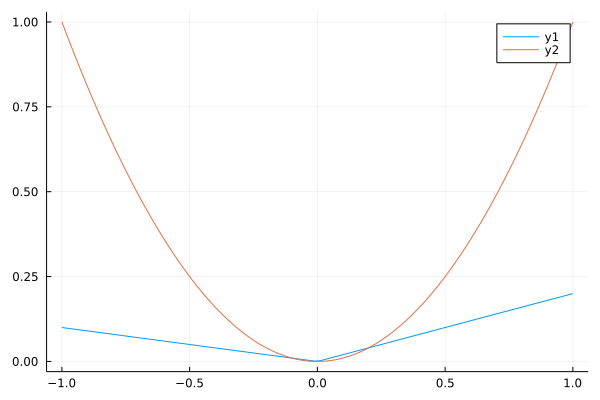

In [109]:
# Initialise arbitrary weights
A = [0.1 0.1 0.1]
B = [1;-1;1]

# Plot the initial output
yhat = nn(A, B, x)
plot(x', vec(yhat))
plot!(x', y')

In [110]:
losses = []
EPOCHS = 100
lr = 0.001

# TRAIN
for i=1:100
    # Fit the model
    yhat = nn(A, B, x)
    
    # Measure the loss
    loss = rss(y, yhat)
    append!(losses, loss)
    
    # Calculate the gradients
    Ag = Agrad(x, A, B, y, yhat)
    Bg = Bgrad(x, A, B, y, yhat)
    
    # Backpropogate
    A, B = opt(Ag, Bg, A, B, lr)
end

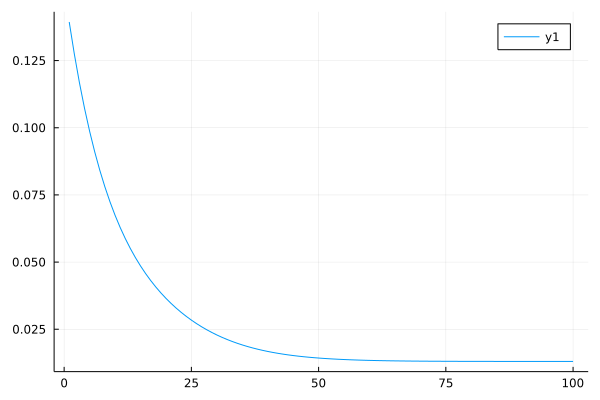

In [111]:
plot(losses)

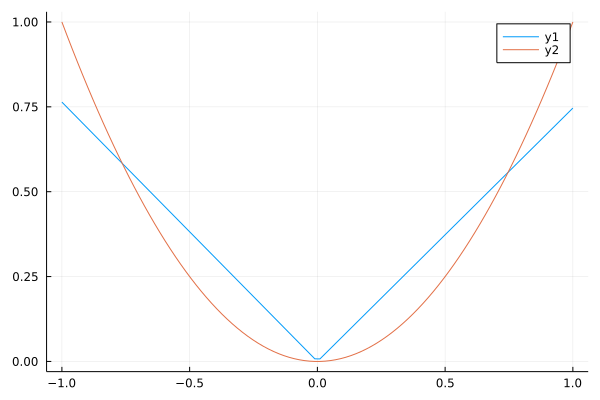

In [112]:
yhat = nn(A, B, x)
plot(x', vec(yhat))
plot!(x', y')

# Using Flux

We can do all of this with the the built in library, Flux in Julia

In [113]:
using Flux
using Plots

x = range(1, 2*2π, 10000)
y = x.^2

# Transopose as Matrices
x = x'
y = y'


flux_opt = Adam(1E-1)

model_flux = Chain(
    Dense(1 => 3, relu),
    Dense(3 => 1))

flux_loss(x, y) = Flux.Losses.mse(model_flux(x), y)

parameters = Flux.params(model_flux)

data = [(x, y)]

# Train the model
flux_losses = []
@time for epoch in 1:500
    # Print
    lossval = flux_loss(x, y)
    # print("$epoch: $lossval\n")
    append!(flux_losses, lossval)

    # Train
    Flux.train!(flux_loss, parameters, data, flux_opt)
end

plot(flux_losses)

plot(x', y')
plot!(x', model_flux(x)')

LoadError: ArgumentError: Package Flux not found in current path.
- Run `import Pkg; Pkg.add("Flux")` to install the Flux package.